### Query Questions

- what is average check associated with each main / combo?
- what are the top three selling mains by Daypart?
    - quantity?
    - sales amount?
- which store sold the most waffles?
- TREND QUESTION
    - what is average check over time (by day?)
    - what are the sales dollars of waffles over time (by day?)

In [1]:
# tasks for this notebook

# load data from CSV
# create tables in a sql database
# insert the data into the tables

In [3]:
import os
import pandas as pd
# Set pandas display options to include commas for integers
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None  # Ensure all columns are displayed
import sqlite3
import matplotlib.pyplot as plt

In [4]:
files = os.listdir("./data/db_data")
files

['order_summary.csv',
 'dim_daypart.csv',
 'dim_location.csv',
 'order_item_detail.csv',
 'product_margin.csv']

In [8]:
# load just the first couple rows of each file to see what the data looks like
file = files[0]
print(file)
pd.read_csv(f"./data/db_data/{file}", nrows=2)

order_summary.csv


,transaction_id,net_sales,store_id,date,order_time
0,1,101.37,71,2024-08-22,17:16
1,2,9.99,8,2024-08-01,13:26


In [9]:
file = files[1]
print(file)
pd.read_csv(f"./data/db_data/{file}", nrows=2)

dim_daypart.csv


,minute_id,daypart
0,0:00,Latenight
1,0:01,Latenight


In [10]:
file = files[2]
print(file)
pd.read_csv(f"./data/db_data/{file}", nrows=2)

dim_location.csv


,store_id,street_address,city,zip_code,dma_name,franchise_owner,franchise_name
0,1,123 Main St,Lindaview,10178,New York,Annette Turner,Turner Food Inc
1,2,124 Main St,Deannaland,60304,Chicago,Alexis Jefferson,Jefferson Food Inc


In [11]:
file = files[3]
print(file)
pd.read_csv(f"./data/db_data/{file}", nrows=2)

order_item_detail.csv


,oid_id,transaction_id,product_id,product_quantity
0,11,1,1311,4
1,12,1,1121,1


In [12]:
file = files[4]
print(file)
pd.read_csv(f"./data/db_data/{file}", nrows=2)

product_margin.csv


,product_id,category,sub_category,product_line,product_name,avg_price,avg_cogs,avg_labor,avg_gross_margin
0,1111,entree,sandwich,beef_burger,hamburger,6.99,2.03,3.15,1.82
1,1112,entree,sandwich,beef_burger,cheeseburger,7.49,2.17,3.37,1.95


In [13]:
files

['order_summary.csv',
 'dim_daypart.csv',
 'dim_location.csv',
 'order_item_detail.csv',
 'product_margin.csv']

In [18]:
# Load data into DataFrames
order_summary_df = pd.read_csv('./data/db_data/order_summary.csv')
order_item_df = pd.read_csv('./data/db_data/order_item_detail.csv')
product_margin_df = pd.read_csv('./data/db_data/product_margin.csv')
locations_df = pd.read_csv('./data/db_data/dim_location.csv')
dim_daypart_df = pd.read_csv('./data/db_data/dim_daypart.csv')

# Create a connection to the SQLite database
conn = sqlite3.connect('data.db')
cur = conn.cursor()

In [19]:

# Helper function to create a table with inferred schema and specified primary key
def create_table_with_schema(df, table_name, primary_key, foreign_keys=None):
    # Infer schema from DataFrame
    columns = []
    for col, dtype in zip(df.columns, df.dtypes):
        sql_type = 'TEXT'
        if 'int' in str(dtype):
            sql_type = 'INTEGER'
        elif 'float' in str(dtype):
            sql_type = 'REAL'
        columns.append(f'"{col}" {sql_type}')
    
    # Add primary key
    columns = [f'{col} PRIMARY KEY' if col.split()[0] == primary_key else col for col in columns]
    
    # Add foreign keys
    if foreign_keys:
        for fk, ref in foreign_keys.items():
            columns.append(f'FOREIGN KEY ("{fk}") REFERENCES {ref}')
    
    # Create table SQL statement
    create_table_sql = f'CREATE TABLE {table_name} ({", ".join(columns)});'
    
    # Execute the create table statement
    cur.execute(create_table_sql)
    
    # Insert data into the new table
    df.to_sql(table_name, conn, if_exists='append', index=False)

# Define schema modifications
schema_modifications = {
    "order_summary": {
        "primary_key": "transaction_id",
        "foreign_keys": {
            "store_id": "locations('store_id')", 
            "order_time": "dim_daypart('minute_id')"
        }
    },
    "order_item": {
        "primary_key": "oid_id",
        "foreign_keys": {
            "transaction_id": "order_summary('transaction_id')",
            "product_id": "product_margin('product_id')"
        }
    },
    "product_margin": {
        "primary_key": "product_id"
    },
    "locations": {
        "primary_key": "store_id"
    },
    "dim_daypart": {
        "primary_key": "minute_id"
    }
}

# Apply schema modifications
for table_name, schema in schema_modifications.items():
    df = eval(f'{table_name}_df')
    create_table_with_schema(df, f'new_{table_name}', schema['primary_key'], schema.get('foreign_keys'))

    # Drop the old table and rename the new table
    cur.execute(f'DROP TABLE IF EXISTS {table_name}')
    cur.execute(f'ALTER TABLE new_{table_name} RENAME TO {table_name}')

# Commit the changes and close the connection
conn.commit()
conn.close()

# Queries

In [20]:
# show the schema of the database
conn = sqlite3.connect('data.db')
cur = conn.cursor()

# Get the schema of the database
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

# Display the schema of each table
for table in tables:
    table_name = table[0]
    print(f"Table: {table_name}")
    cur.execute(f"PRAGMA table_info({table_name})")
    columns = cur.fetchall()
    for col in columns:
        print(col)
    print()

Table: order_summary
(0, 'transaction_id', 'INTEGER', 0, None, 0)
(1, 'net_sales', 'REAL', 0, None, 0)
(2, 'store_id', 'INTEGER', 0, None, 0)
(3, 'date', 'TEXT', 0, None, 0)
(4, 'order_time', 'TEXT', 0, None, 0)

Table: order_item
(0, 'oid_id', 'INTEGER', 0, None, 0)
(1, 'transaction_id', 'INTEGER', 0, None, 0)
(2, 'product_id', 'INTEGER', 0, None, 0)
(3, 'product_quantity', 'INTEGER', 0, None, 0)

Table: product_margin
(0, 'product_id', 'INTEGER', 0, None, 0)
(1, 'category', 'TEXT', 0, None, 0)
(2, 'sub_category', 'TEXT', 0, None, 0)
(3, 'product_line', 'TEXT', 0, None, 0)
(4, 'product_name', 'TEXT', 0, None, 0)
(5, 'avg_price', 'REAL', 0, None, 0)
(6, 'avg_cogs', 'REAL', 0, None, 0)
(7, 'avg_labor', 'REAL', 0, None, 0)
(8, 'avg_gross_margin', 'REAL', 0, None, 0)

Table: locations
(0, 'store_id', 'INTEGER', 0, None, 0)
(1, 'street_address', 'TEXT', 0, None, 0)
(2, 'city', 'TEXT', 0, None, 0)
(3, 'zip_code', 'INTEGER', 0, None, 0)
(4, 'dma_name', 'TEXT', 0, None, 0)
(5, 'franchise_owne

In [21]:
# simply list the table names in the database
query = """
SELECT name FROM sqlite_master WHERE type='table';
"""
cur.execute(query)
tables = cur.fetchall()

# display table names
table_names = [table[0] for table in tables]
print(table_names)

['order_summary', 'order_item', 'product_margin', 'locations', 'dim_daypart']


In [22]:
# for getting the first couple rows of a table
def fetch_head(table: str):
    # Create a connection to the SQLite database
    conn = sqlite3.connect('data.db')
    cur = conn.cursor()
    
    # execute query
    df = pd.read_sql(f"SELECT * FROM {table} LIMIT 2", conn)
    # close the connection
    conn.close()
    print(table)
    return df

In [23]:
# helper function to execute a query
def execute_query(query):
    # Create a connection to the SQLite database
    conn = sqlite3.connect('data.db')
    cur = conn.cursor()
    
    df = pd.read_sql(f"{query}", conn)
    # Close the connection
    conn.close()
    return df

In [24]:
fetch_head(table_names[1])

order_item


,oid_id,transaction_id,product_id,product_quantity
0,11,1,1311,4
1,12,1,1121,1


In [26]:
# Query to sum the total net sales by daypart and order the results
query = """
    SELECT dim_daypart.daypart, SUM(order_summary.net_sales) AS total_sales
    FROM order_summary
    JOIN dim_daypart ON order_summary.order_time = dim_daypart.minute_id
    GROUP BY dim_daypart.daypart
    ORDER BY 
        CASE dim_daypart.daypart
            WHEN 'Breakfast' THEN 1
            WHEN 'Lunch' THEN 2
            WHEN 'Snack' THEN 3
            WHEN 'Dinner' THEN 4
            WHEN 'Latenight' THEN 5
        END;
"""

# Execute the query
result = execute_query(query)
result

,daypart,total_sales
0,Breakfast,"207,579.72"
1,Lunch,"1,625,935.16"
2,Snack,"415,050.28"
3,Dinner,"1,233,405.07"
4,Latenight,"624,008.17"


In [27]:
query = "SELECT dma_name, store_id FROM locations LIMIT 5"
execute_query(query)

,dma_name,store_id
0,New York,1
1,Chicago,2
2,Philadelphia,3
3,Pittsburgh,4
4,Boston (Manchr),5


## Queries
- create queries to add to context
##### Completed
- what is average check associated with each Product?

- what are the top three selling mains by Daypart?
    - quantity?

- which store sold the most waffles?

- TREND QUESTION
    - what is average check over time (by day)

#### Incomplete
   
- TREND QUESTION
    - what is the average check over time (by day) for each DMA

In [28]:
table_names

['order_summary', 'order_item', 'product_margin', 'locations', 'dim_daypart']

In [29]:
# Question:
# What is the average check for each Product Name?

query = """
    SELECT
    product_margin.product_name, 
    AVG(order_summary.net_sales) AS avg_check
    
    FROM order_summary
    INNER JOIN product_margin ON order_item.product_id = product_margin.product_id
    INNER JOIN order_item ON order_summary.transaction_id = order_item.transaction_id
    GROUP BY product_margin.product_name
    ORDER BY avg_check DESC;
"""

# Execute the query
result = execute_query(query)
result


,product_name,avg_check
0,chicken_loco_moco,62.86
1,beef_loco_moco,62.60
2,bacon_me_crazy_burger,59.17
3,breakfast_burger,58.87
4,fried_chicken_sandwich,58.82
5,spicy_chicken_sandwich,57.84
6,smashburger,57.43
7,chicken_bacon_ranch_wrap,56.67
8,grilled_chicken_sandwich,56.16
9,chicken_caesar_wrap,55.69


In [30]:
# Question:
# what are the top three products sold in each daypart?

# sum the `order_item.product_quantity` of each `product_margin.product_name` grouped by `dim_daypart.daypart`. 
# join to the `order_summary` table to get the `minute_id` column
# only return the top three results for each daypart

query = """
    WITH ranked_products AS (
        SELECT
            dim_daypart.daypart,
            product_margin.product_name,
            SUM(order_item.product_quantity) AS total_quantity,
            ROW_NUMBER() OVER (PARTITION BY dim_daypart.daypart ORDER BY SUM(order_item.product_quantity) DESC) AS rank
        FROM order_item
        JOIN product_margin ON order_item.product_id = product_margin.product_id
        JOIN order_summary ON order_item.transaction_id = order_summary.transaction_id
        JOIN dim_daypart ON order_summary.order_time = dim_daypart.minute_id
        GROUP BY dim_daypart.daypart, product_margin.product_name
    )
    SELECT
        daypart,
        product_name,
        total_quantity
    FROM ranked_products
    WHERE rank <= 3
    ORDER BY 
        CASE daypart
            WHEN 'Breakfast' THEN 1
            WHEN 'Lunch' THEN 2
            WHEN 'Snack' THEN 3
            WHEN 'Dinner' THEN 4
            WHEN 'Latenight' THEN 5
        END,
        total_quantity DESC;
"""
# Execute the query
result = execute_query(query)
result

,daypart,product_name,total_quantity
0,Breakfast,spicy_chicken_sandwich,1232
1,Breakfast,waffle_small,1209
2,Breakfast,tea_large,1200
3,Lunch,tea_large,9157
4,Lunch,coffee_large,9055
5,Lunch,waffle_small,9013
6,Snack,beef_loco_moco,2368
7,Snack,waffle_small,2366
8,Snack,chicken_caesar_wrap,2350
9,Dinner,spicy_chicken_sandwich,6835


In [32]:
# Question:
# Which Store sold the most waffles by quantity?

query = """
    SELECT
        locations.dma_name,
        locations.store_id,
        SUM(order_item.product_quantity) AS total_waffles
    FROM order_item
    JOIN product_margin ON order_item.product_id = product_margin.product_id
    JOIN order_summary ON order_item.transaction_id = order_summary.transaction_id
    JOIN locations ON order_summary.store_id = locations.store_id
    WHERE LOWER(product_margin.product_name) LIKE '%waffle%'
    GROUP BY locations.dma_name, locations.store_id
    ORDER BY total_waffles DESC;
"""

# Execute the query
result = execute_query(query)
result

,dma_name,store_id,total_waffles
0,Dallas-Ft.Worth,26,586
1,Dallas-Ft.Worth,8,574
2,Philadelphia,37,561
3,New York,28,523
4,Pittsburgh,80,518
...,...,...,...
95,Dallas-Ft.Worth,82,381
96,Philadelphia,3,380
97,Philadelphia,75,378
98,Philadelphia,79,367


In [33]:
# Question:
# What is the average check over time?

# use the `order_summary.totnetsales` column to calculate the average
# group by `order_summary.busidaydt` and `locations.DMA`
# order by `order_summary.busidaydt`

query = """
    SELECT
        order_summary.date,
        AVG(order_summary.net_sales) AS avg_check
    FROM order_summary
    GROUP BY order_summary.date
    ORDER BY order_summary.date;
    """

# Execute the query
result = execute_query(query)
result

,date,avg_check
0,2024-07-01,39.96
1,2024-07-02,40.17
2,2024-07-03,40.97
3,2024-07-04,41.31
4,2024-07-05,40.01
...,...,...
86,2024-09-25,41.82
87,2024-09-26,40.85
88,2024-09-27,41.95
89,2024-09-28,41.19


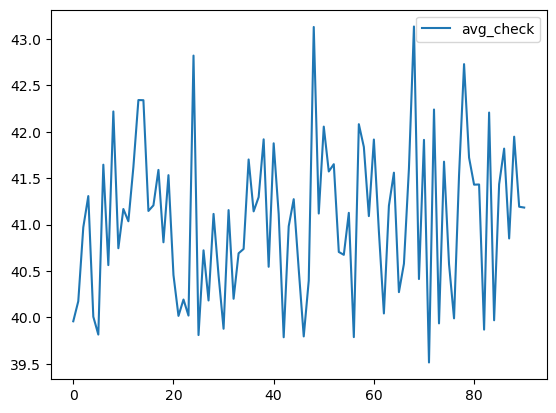

In [34]:
result.plot();

In [35]:
# Question:
# what is the average check over time by DMA?

# use the `order_summary.net_sales` column to calculate the average
# use the `locations.dma_name` column to determine the region
# group by `order_summary.date` and `locations.dma_name`
# order by `order_summary.date`

query = """
    SELECT
        order_summary.date,
        locations.dma_name,
        AVG(order_summary.net_sales) AS avg_check
    FROM order_summary
    JOIN locations ON order_summary.store_id = locations.store_id
    GROUP BY order_summary.date, locations.dma_name
    ORDER BY order_summary.date;
"""

# Execute the query
result = execute_query(query)
result

,date,dma_name,avg_check
0,2024-07-01,Boston (Manchr),40.92
1,2024-07-01,Chicago,46.68
2,2024-07-01,Dallas-Ft.Worth,38.85
3,2024-07-01,Los Angeles,40.02
4,2024-07-01,Mineapls-St. Pl,39.43
...,...,...,...
814,2024-09-29,Mineapls-St. Pl,42.62
815,2024-09-29,New York,42.59
816,2024-09-29,Philadelphia,37.88
817,2024-09-29,Pittsburgh,46.40


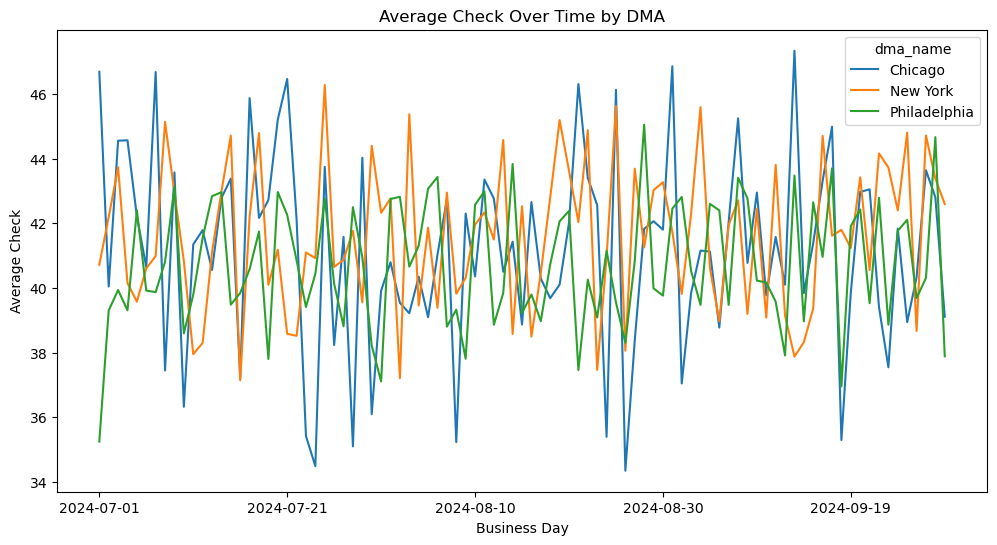

In [36]:
# select a subset of DMAs to plot
plot_df = result[result['dma_name'].isin(['Chicago', 'New York', 'Philadelphia'])]

# Pivot the DataFrame
pivot_df = plot_df.pivot(index='date', columns='dma_name', values='avg_check')

# Plot the average check for each DMA
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(ax=ax)

# Set plot labels and title
ax.set_xlabel('Business Day')
ax.set_ylabel('Average Check')
ax.set_title('Average Check Over Time by DMA')

# Display the plot
plt.show()

In [37]:
query = """
SELECT DISTINCT "daypart" FROM dim_daypart LIMIT 5;
"""

execute_query(query)

,daypart
0,Latenight
1,Breakfast
2,Lunch
3,Snack
4,Dinner


In [38]:
fetch_head('locations')

locations


,store_id,street_address,city,zip_code,dma_name,franchise_owner,franchise_name
0,1,123 Main St,Lindaview,10178,New York,Annette Turner,Turner Food Inc
1,2,124 Main St,Deannaland,60304,Chicago,Alexis Jefferson,Jefferson Food Inc


In [39]:
# what does the locations data look like?
query = """
    SELECT *
    FROM locations
    LIMIT 5;
"""

# Execute the query
result = execute_query(query)
result

,store_id,street_address,city,zip_code,dma_name,franchise_owner,franchise_name
0,1,123 Main St,Lindaview,10178,New York,Annette Turner,Turner Food Inc
1,2,124 Main St,Deannaland,60304,Chicago,Alexis Jefferson,Jefferson Food Inc
2,3,125 Main St,Port Kaylaville,19006,Philadelphia,Amanda Greene,Greene Food Inc
3,4,126 Main St,West William,15209,Pittsburgh,Corey Prince,Prince Food Inc
4,5,127 Main St,East Stevenland,5141,Boston (Manchr),Melissa Johnson,Johnson Food Inc


In [41]:
# what does the product data look like?
query = """
    SELECT *
    FROM product_margin
    LIMIT 5;
"""

# Execute the query
result = execute_query(query)
result

,product_id,category,sub_category,product_line,product_name,avg_price,avg_cogs,avg_labor,avg_gross_margin
0,1111,entree,sandwich,beef_burger,hamburger,6.99,2.03,3.15,1.82
1,1112,entree,sandwich,beef_burger,cheeseburger,7.49,2.17,3.37,1.95
2,1113,entree,sandwich,beef_burger,smashburger,8.99,2.61,4.05,2.34
3,1114,entree,sandwich,beef_burger,bacon_me_crazy_burger,9.99,2.90,4.50,2.60
4,1115,entree,sandwich,beef_burger,breakfast_burger,9.99,2.90,4.50,2.60


In [42]:
# what are the total sales by store and date?
query = """
    SELECT order_summary.date, locations.store_id, SUM(order_summary.net_sales) AS total_sales
    FROM order_summary
    JOIN locations ON order_summary.store_id = locations.store_id
    GROUP BY order_summary.date, locations.store_id
    ORDER BY order_summary.date, locations.store_id;
"""

# Execute the query
result = execute_query(query)
result

,date,store_id,total_sales
0,2024-07-01,1,468.73
1,2024-07-01,2,318.48
2,2024-07-01,3,616.94
3,2024-07-01,4,387.89
4,2024-07-01,5,302.90
...,...,...,...
9095,2024-09-29,96,626.42
9096,2024-09-29,97,398.31
9097,2024-09-29,98,359.29
9098,2024-09-29,99,437.71


In [45]:
query = """
    SELECT DISTINCT dma_name
    FROM locations
    ORDER BY dma_name ASC
"""

# Execute the query
result = execute_query(query)
result.dropna()

,dma_name
0,Boston (Manchr)
1,Chicago
2,Dallas-Ft.Worth
3,Los Angeles
4,Mineapls-St. Pl
5,New York
6,Philadelphia
7,Pittsburgh
8,"Wash, DC (Hag)"


In [46]:
# what are the top 10 products sold in the Philadelphia DMA?
query = """
    SELECT product_margin.product_name, CAST(SUM(order_item.product_quantity) AS INTEGER) AS total_sold
    FROM order_item
    JOIN product_margin ON order_item.product_id = product_margin.product_id
    JOIN order_summary ON order_item.transaction_id = order_summary.transaction_id
    JOIN locations ON order_summary.store_id = locations.store_id
    WHERE locations.dma_name = 'Philadelphia'
    GROUP BY product_margin.product_name
    ORDER BY total_sold DESC
    LIMIT 10;
"""

# Execute the query
result = execute_query(query)
result

,product_name,total_sold
0,tea_large,4363
1,curly_small,4354
2,hamburger,4281
3,chicken_loco_moco,4269
4,waffle_small,4249
5,coffee_small,4245
6,oreo_pie,4220
7,beef_loco_moco,4204
8,pumpkin_pie,4196
9,smashburger,4193


In [47]:
# what are the total sales by store and date?
query = """
    SELECT order_summary.date, locations.store_id, SUM(order_summary.net_sales) AS total_sales
    FROM order_summary
    JOIN locations ON order_summary.store_id = locations.store_id
    GROUP BY order_summary.date, locations.store_id
    ORDER BY order_summary.date, locations.store_id;
"""

# Execute the query
result = execute_query(query)
result

,date,store_id,total_sales
0,2024-07-01,1,468.73
1,2024-07-01,2,318.48
2,2024-07-01,3,616.94
3,2024-07-01,4,387.89
4,2024-07-01,5,302.90
...,...,...,...
9095,2024-09-29,96,626.42
9096,2024-09-29,97,398.31
9097,2024-09-29,98,359.29
9098,2024-09-29,99,437.71


In [48]:
# what are the total sales by store and date?
query = """
    SELECT order_summary.date, locations.store_id, SUM(order_summary.net_sales) AS total_sales
    FROM order_summary
    JOIN locations ON order_summary.store_id = locations.store_id
    GROUP BY order_summary.date, locations.store_id
    ORDER BY order_summary.date, locations.store_id;
"""

# Execute the query
result = execute_query(query)
result

,date,store_id,total_sales
0,2024-07-01,1,468.73
1,2024-07-01,2,318.48
2,2024-07-01,3,616.94
3,2024-07-01,4,387.89
4,2024-07-01,5,302.90
...,...,...,...
9095,2024-09-29,96,626.42
9096,2024-09-29,97,398.31
9097,2024-09-29,98,359.29
9098,2024-09-29,99,437.71


In [56]:
# what are the monthly sales for store 77?
query = """
    SELECT strftime('%Y-%m', order_summary.date) AS month, SUM(order_summary.net_sales) AS total_sales
    FROM order_summary
    JOIN locations ON order_summary.store_id = locations.store_id
    WHERE locations.store_id = 77
    GROUP BY month
    ORDER BY month;
"""

# Execute the query
result = execute_query(query)
result

,month,total_sales
0,2024-07,"14,514.89"
1,2024-08,"14,508.19"
2,2024-09,"13,427.24"


In [57]:
# how many items on average are included on checks that contain a waffle?
query = """
SELECT AVG(item_count) AS avg_items_per_check
FROM (
    SELECT order_summary.transaction_id, COUNT(order_item.product_id) AS item_count
    FROM order_summary
    JOIN order_item ON order_summary.transaction_id = order_item.transaction_id
    JOIN product_margin ON order_item.product_id = product_margin.product_id
    WHERE LOWER(product_margin.product_name) LIKE '%waffle%'
    GROUP BY order_summary.transaction_id
) AS subquery;
"""

# Execute the query
result = execute_query(query)
result

,avg_items_per_check
0,1.06


In [58]:
# what are the dayparts?
query = """
SELECT 
DISTINCT(daypart)
FROM dim_daypart
ORDER BY
CASE daypart
    WHEN 'Breakfast' THEN 1
    WHEN 'Lunch' THEN 2
    WHEN 'Snack' THEN 3
    WHEN 'Dinner' THEN 4
    WHEN 'Latenight' THEN 5
END;
"""

# Execute the query
result = execute_query(query)
result

,daypart
0,Breakfast
1,Lunch
2,Snack
3,Dinner
4,Latenight


In [59]:
# what are the daypart start and end times?
query = """
SELECT
    daypart,
    MIN(minute_id) AS start_time,
    MAX(minute_id) AS end_time
FROM dim_daypart
GROUP BY daypart
ORDER BY
CASE daypart
    WHEN 'Breakfast' THEN 1
    WHEN 'Lunch' THEN 2
    WHEN 'Snack' THEN 3
    WHEN 'Dinner' THEN 4
    WHEN 'Latenight' THEN 5
END;
"""

# Execute the query
result = execute_query(query)
result

,daypart,start_time,end_time
0,Breakfast,10:00,9:59
1,Lunch,11:00,13:59
2,Snack,14:00,16:59
3,Dinner,17:00,22:59
4,Latenight,0:00,3:59


In [66]:
# what are the daypart start and end times?
query = """
SELECT
*
FROM dim_daypart
WHERE daypart = 'Breakfast'
"""

# Execute the query
result = execute_query(query)
result

,minute_id,daypart
0,4:00,Breakfast
1,4:01,Breakfast
2,4:02,Breakfast
3,4:03,Breakfast
4,4:04,Breakfast
...,...,...
415,10:55,Breakfast
416,10:56,Breakfast
417,10:57,Breakfast
418,10:58,Breakfast


In [81]:
q1 = """
    SELECT 
        locations.dma_name, 
        locations.store_id, 
        SUM(order_item.product_quantity) AS total_waffles 
    FROM 
        order_item 
    JOIN 
        product_margin ON order_item.product_id = product_margin.product_id 
    JOIN 
        order_summary ON order_item.transaction_id = order_summary.transaction_id 
    JOIN 
        locations ON order_summary.store_id = locations.store_id 
    WHERE 
        LOWER(product_margin.product_name) LIKE '%waffle%' 
    GROUP BY 
        locations.dma_name, 
        locations.store_id 
    ORDER BY 
        total_waffles DESC;
"""

execute_query(q1)

,dma_name,store_id,total_waffles
0,Dallas-Ft.Worth,26,586
1,Dallas-Ft.Worth,8,574
2,Philadelphia,37,561
3,New York,28,523
4,Pittsburgh,80,518
...,...,...,...
95,Dallas-Ft.Worth,82,381
96,Philadelphia,3,380
97,Philadelphia,75,378
98,Philadelphia,79,367


In [83]:
q = """
SELECT 
    product_margin.product_name, 
    CAST(SUM(order_item.product_quantity) AS INTEGER) AS total_sold 
FROM 
    order_item 
JOIN 
    product_margin ON order_item.product_id = product_margin.product_id 
JOIN 
    order_summary ON order_item.transaction_id = order_summary.transaction_id 
JOIN 
    locations ON order_summary.store_id = locations.store_id 
WHERE 
    locations.dma_name = 'Philadelphia'
    AND order_summary.date BETWEEN '2024-09-01' AND '2024-09-30'
GROUP BY 
    product_margin.product_name 
ORDER BY 
    total_sold DESC 
LIMIT 10;
"""
results = execute_query(q)
results

,product_name,total_sold
0,coffee_small,1418
1,smashburger,1412
2,oreo_pie,1388
3,tea_large,1381
4,shoestring_small,1377
5,waffle_large,1370
6,curly_small,1368
7,chicken_loco_moco,1367
8,sundae_large,1356
9,breakfast_burger,1343


In [84]:
q = """
SELECT strftime('%Y-%m', order_summary.date) AS MONTH,
       COUNT(order_summary.transaction_id) AS transaction_count
FROM order_summary
JOIN locations ON order_summary.store_id = locations.store_id
WHERE locations.dma_name = 'Philadelphia'
GROUP BY MONTH
ORDER BY MONTH;
"""

execute_query(q)

,MONTH,transaction_count
0,2024-07,6539
1,2024-08,6446
2,2024-09,5956


### Query validation

In [87]:
query = """
SELECT product_margin.product_name,
       SUM(order_item.product_quantity) AS total_sold
FROM order_item
JOIN product_margin ON order_item.product_id = product_margin.product_id
JOIN order_summary ON order_item.transaction_id = order_summary.transaction_id
JOIN dim_daypart ON order_summary.order_time = dim_daypart.minute_id
WHERE dim_daypart.daypart = 'Latenight'
  AND order_summary.store_id = 77
  AND strftime('%Y', order_summary.date) = '2024'
GROUP BY product_margin.product_name
ORDER BY total_sold DESC
LIMIT 1;
"""

# Execute the query
result = execute_query(query)
result

,product_name,total_sold
0,smashburger,47


In [88]:
# Query to sum the total net sales by daypart and order the results
query = """
SELECT strftime('%Y-%m', order_summary.date) AS MONTH,
       SUM(order_summary.net_sales) AS total_sales
FROM order_summary
JOIN locations ON order_summary.store_id = locations.store_id
WHERE locations.store_id = 77
  AND order_summary.date LIKE '2024%'
GROUP BY MONTH
ORDER BY MONTH;
"""

# Execute the query
result = execute_query(query)
result

,MONTH,total_sales
0,2024-07,"14,514.89"
1,2024-08,"14,508.19"
2,2024-09,"13,427.24"
